# Debiasing word embeddings

In [11]:
import csv
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Model download

We use Microsoft Pri-2 model - transformer with $2.7$ billion parameters.

You can download it [here](https://huggingface.co/microsoft/phi-2).

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Indicating the bias

To measure the similarity between two words represented by their embeddings, we are going to use cosine similarity.

Firstly, we define the list of words that are aimed to be gender-neutral.

In [4]:
gender_neutral_words = []

with open("neutral_words.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      for word in row:
        gender_neutral_words.append(word.strip())

Secondly, we want to be able to tokenize the words (meaning representing a word as a high-dimensional vector).

In [5]:
def get_embeddings(word: str):
  '''
  Get vector embedding of a specific word.
  '''
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokens = tokenizer(word, return_tensors="pt", padding = True, return_attention_mask=False)
  print(tokens)
  with torch.no_grad():
      outputs = model(**tokens)
  tokens_current = outputs.hidden_states[0].cpu()
  tokens_current.shape
  return tokens_current[0][0]

For example:

In [6]:
print(get_embeddings("dog"))

{'input_ids': tensor([[9703]], device='cuda:0')}
tensor([-0.0034,  0.0041,  0.0026,  ...,  0.0219, -0.0308, -0.0073],
       dtype=torch.float16)


In [7]:
outputs = model(torch.tensor([[50000]]))
tokens_current = outputs.hidden_states[0].cpu()
print(tokens_current)

tensor([[[ 0.0213,  0.0339, -0.0301,  ...,  0.0028, -0.0131, -0.0156]]],
       dtype=torch.float16, grad_fn=<ToCopyBackward0>)


Cosine similarity computes the cosine of the angle between the vectors of the two words in the embedding space. The formula for the cosine between two vectors is defined as:

$$ \cos(\vec{u}, \vec{v}) = \frac{\vec{u}\vec{v}}{\lVert \vec{u} \rVert \lVert \vec{v} \rVert}, $$

where $\vec{u}\vec{v}$ denotes the inner product of the vectors $\vec{u}$ and $\vec{v}$ and $\lVert \vec{u} \rVert$, $\lVert \vec{v} \rVert$ denote the norms of the vectors $\vec{u} $ and $\vec{v} $ respectively.

It quantifies the similarity in direction between the vectors, with a value close to $1$ indicating high similarity and a value close to $-1$ indicating dissimilarity. However, it does not capture the magnitudes of the vectors.  In the context of ensuring fairness or lack of bias, we aim for equal cosine similarities between a given word and two gender-specific terms, typically male and female. For instance, if we consider the word 'business' as gender-neutral, then the cosine similarity between $\overrightarrow{business}$ and $\overrightarrow{male}$ should ideally be equal to the cosine similarity between $\overrightarrow{business}$ and $\overrightarrow{female}$, or at least very close to each other. This ensures that the representation of the word 'business' in the embedding space exhibits neutrality with respect to gender associations.

As a metrics of the biasness we chose the absolute difference between the cosine similarities of the word and two gender-specific words. For instance, for word $\vec{w}$:

$$\mbox{difference} = |cos(\overrightarrow{w}, \overrightarrow{\mbox{he}}) - cos(\overrightarrow{w}, \overrightarrow{\mbox{she}})|$$
The smaller is this difference, the less bias the particular word has.

In [8]:
def cosine_similarity(u, v):
  '''
  Calculates the cosine similarity bettwen two vectors.
  It is the inner product of two vectors divided by product of their norms.
  '''
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def calculate_gender_bias(neutral_word, male_gender, female_gender):
  '''
  Calculates the bias. If the sign is positive - the word is biased in male direction; if negative - in female direction.
  '''
  return cosine_similarity(neutral_word, male_gender) - cosine_similarity(neutral_word, female_gender)

def calculate_difference(neutral_word, male_gender, female_gender):
  '''
  Calculates the absolute difference between cosine similarities of two vectors with other.
  '''
  return abs(calculate_gender_bias(neutral_word, male_gender, female_gender))

### Define gender-specific words

To define the gender-specific subspace $G$ we need to define the pairs of gender-specific words:

In [10]:
gender_words_female = []
gender_words_male = []

with open("female_words.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      for word in row:
        gender_words_female.append(word.strip())

with open("male_words.csv", newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      for word in row:
        gender_words_male.append(word.strip())

tokens_list = []
tokenizer.pad_token = tokenizer.eos_token
for index, pair in enumerate(zip(gender_words_female, gender_words_male)):
  embeddings = []
  tokens = tokenizer(pair, return_tensors="pt", padding = True, return_attention_mask=False)
  with torch.no_grad():
      outputs = model(**tokens)
  tokens_current = outputs.hidden_states[0].cpu()
  if tokens_current.shape == torch.Size([2, 1, 2560]):
    tokens_list.append(pair)

Then, we choose only words that are represented by a single token:

In [13]:
tokens = tokenizer("mr", return_tensors="pt", padding = True, return_attention_mask=False)
with torch.no_grad():
    outputs = model(**tokens)
tokens_current = outputs.hidden_states[0].cpu()

In [14]:
set(tokens_list)

{('aunt', 'uncle'),
 ('daughter', 'son'),
 ('female', 'male'),
 ('girl', 'boy'),
 ('her', 'his'),
 ('lass', 'lad'),
 ('miss', 'mr'),
 ('mom', 'dad'),
 ('mother', 'father'),
 ('she', 'he'),
 ('wife', 'husband'),
 ('woman', 'man'),
 ('women', 'men')}

As we can see, we defined the $13$ pairs of gender-specific words.

### Form differences of gender-specific words

So we need to form the vectors as differences of the above vectors, because the differences define the gender subset.

In [15]:
def get_embeddings(word: str):
  '''
  Get vector embedding of a specific word.
  '''
  tokens = tokenizer(word, return_tensors="pt", padding = True, return_attention_mask=False)
  with torch.no_grad():
      outputs = model(**tokens)
  tokens_current = outputs.hidden_states[0].cpu()
  tokens_current.shape
  return tokens_current[0][0]

In [16]:
words = [('aunt', 'uncle'),
 ('daughter', 'son'),
 ('female', 'male'),
 ('girl', 'boy'),
 ('her', 'his'),
 ('lass', 'lad'),
 ('miss', 'mr'),
 ('mom', 'dad'),
 ('mother', 'father'),
 ('she', 'he'),
 ('wife', 'husband'),
 ('woman', 'man'),
 ('women', 'men')
]

difference_vectors = []
for word_female, word_male in words:
  differece = get_embeddings(word_female) - get_embeddings(word_male)
  difference_vectors.append(differece)


difference_vectors = np.array(difference_vectors)
difference_vectors = difference_vectors.astype(np.float32)

Now we have $13$ vectors that define the gender subset $G$.

### Dimensionality reduction

In order to word with less than $13$ vectors that define $G$, we use the principal component analysis to find the $k$ most significant vectors in this affine set. Also, this vectors will be orthogonal.

PCA analyzes the variance of the data in its original basis and aims  identify the directions in which the variance is maximal. Subsequently, PCA utilizes first $k$ significant directions to define the new basis.

Let difference vectors be $v_1, ..., v_n$.

To perform PCA, we need to construct a matrix taking vectors $v_1, ..., v_n$ as rows:

$$X = \begin{bmatrix}
    v_{1}\\
    v_{2}\\
    \cdots\\
    v_{13}  
 \end{bmatrix}$$


 Then, we need to center the matrix $X$ by subtracting its mean from it:

$$X_{i, j} = X_{i, j} - \bar{X_j},$$

 where $X_{i, j}$ denotes the $(i, j)$-th element of $X$ and $\bar{X_j}$ denotes the mean value of the variable $X_j$.

Now we need to construct the covariance matrix of matrix $X$, which is defined as


$$C = \begin{bmatrix}
    \mbox{Var}(X_1) & \mbox{Cov}(X_1, X_2) & ... & \mbox{Cov}(X_1, X_n) \\
    \mbox{Cov}(X_2, X_1) & \mbox{Var}(X_2) & ... & \mbox{Cov}(X_1, X_n) \\
    \cdots & \cdots & \cdots & \cdots\\
    \mbox{Cov}(X_n, X_1) & \mbox{Cov}(X_n, X_2) & ... & \mbox{Var}(X_n)
 \end{bmatrix}$$
In our case:
 $$C = XX^T = \begin{bmatrix}
    v_1v_1^T & v_1v_2^T & ... & v_1v_n^T \\
    v_2v_1^T & v_2v_2^T & ... & v_2v_n^T \\
    \cdots & \cdots & \cdots & \cdots\\
    v_nv_1^T & v_nv_2^T & ... & v_nv_n^T
 \end{bmatrix}$$

Note that this matrix is symmetric since $\mbox{Cov}(X_i, X_ j) = \mbox{Cov}(X_j, X_i)$.

Next, we proceed to find the eigenvalues and eigenvectors of the matrix $C$.
Suppose the $\lambda_1, \lambda_2, ..., \lambda_n$ are eigenvalues of the matrix $C$, sorted in the descending order. Then the first $k$ eigenvectors are considered to be principal eigenvectors and the $\frac{\lambda_i}{\sum{\lambda_j}}$ is the proportion of variance explained by the $i$-th eigenvector.


In [17]:
n, p =  2560, 13
X = difference_vectors.T
X -= np.mean(X, axis=0)

C = np.cov(X, rowvar=False)
l, principal_axes = la.eig(C)

idx = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
principal_components = X.dot(principal_axes)

Now, our task is to determine the appropriate value for $k$. One common method used for this purpose is the Elbow method. It aims to plot the cumulative explained variance agains the number of components.

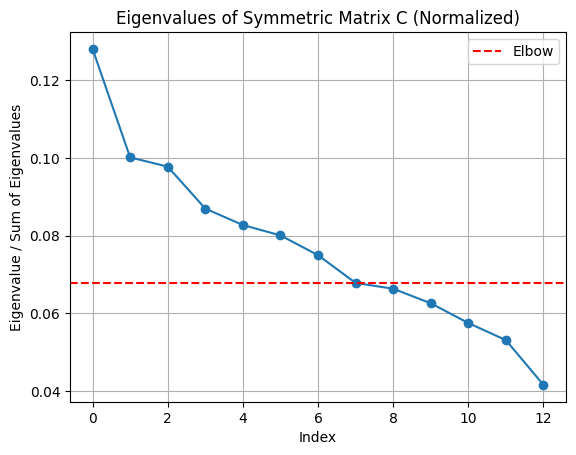

In [18]:
eigenvalues, eigenvectors = la.eigh(C)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

eigenvalue_sum = np.sum(sorted_eigenvalues)

normalized_eigenvalues = sorted_eigenvalues / eigenvalue_sum

plt.plot(normalized_eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue / Sum of Eigenvalues')
plt.title('Eigenvalues of Symmetric Matrix C (Normalized)')
plt.grid(True)

plt.axhline(y=normalized_eigenvalues[7], color='r', linestyle='--', label='Elbow')

plt.legend()
plt.show()


Once $k$ reaches 7, it becomes apparent from the graph that additional reductions do not result in a significant decrease. Therefore, we have opted for $k=7$ and have extracted the first 7 eigenvectors for further analysis to serve as the basis vectors for the space $G$. These eigenvectors are denoted as $g_1, ..., g_7$. Being eigenvectors of a symmetric matrix, they are pairwise orthogonal.

In [19]:
k = 7
PCA_k = principal_components[:, 0:k]

### Soft debiasing

To neutralize the bias component of a given word vector $\vec{w}$, we aim to project this vector onto the gender-neutral subspace $N$. Given that $N + G = \mathbb{R}^d$, the spaces $G$ and $N$ are orthogonal. Consequently, every vector $\vec{w} \in \mathbb{R}^d$ can be decomposed as:

$$\vec{w} = \vec{w_{G}} + \vec{w_{N}},$$

where $\vec{w_{N}}$ represents the projection of $\vec{w}$ onto the affine space $N$, and $\vec{w_{G}}$ signifies the projection onto $G$.

Therefore,
$$\vec{w_{N}} = \vec{w} - \vec{w_{G}}$$

Given that the basis vectors of $G$ are orthogonal, we can obtain $\vec{w_{G}}$ as the sum of the projections onto these basis vectors:

$$\vec{w_{G}} = \sum_{i=1}^{7}{\vec{w_{g_i}}}$$
where $\vec{w_{g_i}}$ denotes the projection of $\vec{w}$ onto the basis vector $g_i$.
The projection matrix onto the linear span of $g_i$ is defined as:

$$P_{g_i} = \frac{g_ig_i^T}{g_i^Tg_i}$$

So the overall projection is calculated as follows:

$$\vec{w_{G}} = \sum_{i=1}^{7}{P_{g_i}g_i} = \sum_{i=1}^{7}{\frac{g_ig_i^T}{g_i^Tg_i}g_i}$$

In [20]:
projectors = []
for i in range(PCA_k.shape[-1]):
  a = PCA_k[:, i]
  projectors.append(np.outer(a, a) / np.inner(a, a))

### Example of debiasing

The debiased vector looks as follows:

$$\vec{w_{N}} = \vec{w} - \sum_{i=1}^{7}{P_{g_i}g_i} = \vec{w} - \sum_{i=1}^{7}{\frac{g_ig_i^T}{g_i^Tg_i}g_i}$$

In [22]:
def debias_word(word):
  '''
  Debiasing the word by taking projection.
  '''
  projection = projectors[0] @ word
  for i in range(1, 7):
    projection += projectors[i] @ word
  return word - projection

In [23]:
football = get_embeddings("football").numpy()

male = get_embeddings(words[2][0]).numpy()
female = get_embeddings(words[2][1]).numpy()

In [24]:
unbiased = debias_word(football)

Cosine similarities before the debias:

In [25]:
print(cosine_similarity(football, male))
print(cosine_similarity(football, female))

0.006195
0.02847


Cosine similarities after the debias:

In [26]:
print(cosine_similarity(unbiased, male))
print(cosine_similarity(unbiased, female))

0.009280318264304005
0.023902558998021205


In [28]:
print('Difference before:', calculate_difference(football, male, female))
print('Difference after:', calculate_difference(unbiased, male, female))

Difference before: 0.02228
Difference after: 0.0146222407337172


### Debiasing list of words

In [29]:
cosine_similarities = []

for word_neutral in gender_neutral_words:
  embedding = get_embeddings(word_neutral)
  cosine_similarities.append((word_neutral, calculate_difference(embedding, male, female)))

sorted_cosine_similarities = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)

print(sorted_cosine_similarities[:20])

[('process', 0.09344), ('protector', 0.0796), ('specialist', 0.0745), ('partner', 0.0619), ('country', 0.06012), ('art', 0.0594), ('state', 0.05792), ('state', 0.05792), ('technician', 0.05716), ('technique', 0.05716), ('universe', 0.0534), ('university', 0.0534), ('taxpayer', 0.05338), ('star', 0.05276), ('philanthropist', 0.0502), ('scheme', 0.04855), ('performer', 0.0467), ('friend', 0.04602), ('business', 0.0458), ('division', 0.04553)]


In [30]:
len(gender_neutral_words)

429

In [32]:
differences_before = []
differences_after = []
unbiased_list = []

def soft_debias(word):
  he = get_embeddings('he').numpy()
  she = get_embeddings('she').numpy()
  word = get_embeddings(word).numpy()
  differences_before.append(calculate_difference(word, he, she))
  projection = (projectors[0] @ word + projectors[1] @ word+ projectors[2] @ word +
          projectors[3] @ word+ projectors[4] @ word +
          projectors[5] @ word+ projectors[6] @ word)
  unbiased = word - projection

  return unbiased
for word in gender_neutral_words[:50]:

  debiased = soft_debias(word)
  unbiased_list.append(debiased)
  differences_after.append(calculate_difference(debiased, he, she))

print("Before:", differences_before)
print("After:", differences_after)

Before: [0.0394, 0.02985, 0.02005, 0.163, 0.02419, 0.02621, 0.1254, 0.1254, 0.1254, 0.0939, 0.0010605, 0.0084, 0.04654, 0.0206, 0.0626, 0.0372, 0.008965, 0.013245, 0.01236, 0.02142, 0.1404, 0.00598, 0.06683, 0.01352, 0.05386, 0.00454, 0.01822, 0.05295, 0.10345, 0.04004, 0.02376, 0.1562, 0.00763, 0.169, 0.03833, 0.0265, 0.02933, 0.0435, 0.0204, 0.002075, 0.00899, 0.03284, 0.04327, 0.04575, 0.02055, 0.1506, 0.1045, 0.01439, 0.04092, 0.02856]
After: [0.006627842734166247, 0.006931869223732828, 0.003318229461766001, 0.007552872863474121, 0.005682225962538933, 0.006051123121759358, 0.009082224916057625, 0.009082224916057625, 0.009082224916057625, 0.006183336750473185, 4.799080588289463e-05, 0.004190502771109941, 0.007604939096489398, 0.0075839230575165915, 0.006967585096120908, 0.006469283159354399, 0.0029113673142385985, 0.010366411262281827, 0.005365074173747878, 0.0115965157652159, 0.013250024039405534, 0.0035378765905016395, 0.008255401717642719, 0.002300409441365488, 0.0012252852747762

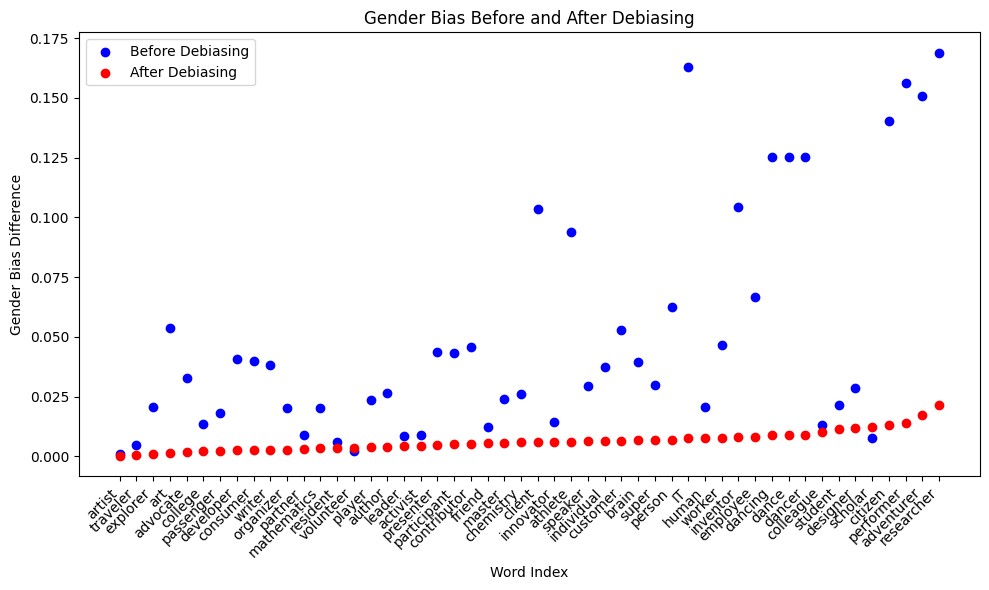

In [33]:
words_and_diffs = list(zip(gender_neutral_words, differences_before, differences_after))
sorted_words_and_diffs = sorted(words_and_diffs, key=lambda x: x[2])

gender_neutral_words_sorted, differences_before_sorted, differences_after_sorted = zip(*sorted_words_and_diffs)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(gender_neutral_words_sorted)), differences_before_sorted, label='Before Debiasing', color='blue')
plt.scatter(range(len(gender_neutral_words_sorted)), differences_after_sorted, label='After Debiasing', color='red')
plt.xlabel('Word Index')
plt.ylabel('Gender Bias Difference')
plt.title('Gender Bias Before and After Debiasing')
plt.legend()
plt.xticks(range(len(gender_neutral_words_sorted)), gender_neutral_words_sorted, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [34]:
unbiased_equalized = []
for w in unbiased_list:
  unbiased_equalized.append(w / np.linalg.norm(w))

### Hard debiasing

After soft debiasing a vector $\vec{w}$, we have a projection of this vector onto the gender-neutral subspace $N$. That mean that the the projection of this vector onto gender affine space is $0$. We have removed bias from word itself, but there is one more step to make it better. Our gender defining words not necessarily is equally distant. In order to make that a case, we use equalization that will make our gender defining words equally distant to all words $\vec{w_{N}}$. We don't have to recalculate distance for every word, as in subspace $N^\perp$  our vectors 0.
$$\mu := \frac{\sum_{w \in E} W}{E}$$
Where $\mu$ is average of the equalization set $E$.
In this formula we take average of every equalization set (in our case pair).
$$v := \mu - \mu_B $$
Where $\mu_B$ is projection of $mu$ onto gender defining subspace.
Then for every $\vec{w}$
$$\vec{w} := \nu + \sqrt{1 - ||\nu||^2} \frac{\vec{w}_B - \mu_B}{||\vec{w}_B - \mu_B||}$$
Where $\vec{w}_B$ projection on gender defining subspaces.
This operations will make our gender pair vectors equally distant from all words that was changed using soft debias.

In [37]:
gender_defining = []

def hard_debias(pair):

  embeddings = get_embeddings(pair[0]).numpy(), get_embeddings(pair[1]).numpy()
  mean = np.mean(embeddings, axis=0)
  v = mean - (projectors[0] @ mean + projectors[1] @ mean)
  v = v / np.linalg.norm(v)
  proj_1 = projectors[0] @ embeddings[0] + projectors[1] @ embeddings[0] - (projectors[0] @ mean + projectors[1] @ mean)
  proj_2 = projectors[0] @ embeddings[1] + projectors[1] @ embeddings[1] - (projectors[0] @ mean + projectors[1] @ mean)
  w_1 = v + (np.sqrt(1 - (np.linalg.norm(v))**2) * proj_1) / np.linalg.norm(proj_1)
  w_2 = v + (np.sqrt(1 - (np.linalg.norm(v))**2) * proj_1) / np.linalg.norm(proj_1)
  return (w_1, w_2)
for pair in words:
  debiased = hard_debias(pair)
  gender_defining.append(debiased)


In [38]:
differences_after_new = []


he = gender_defining[2][0]
she = gender_defining[2][1]

for word_unbiased in unbiased_list:
  differences_after_new.append(calculate_difference(word_unbiased, he, she))

print("After:", differences_after_new)

After: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


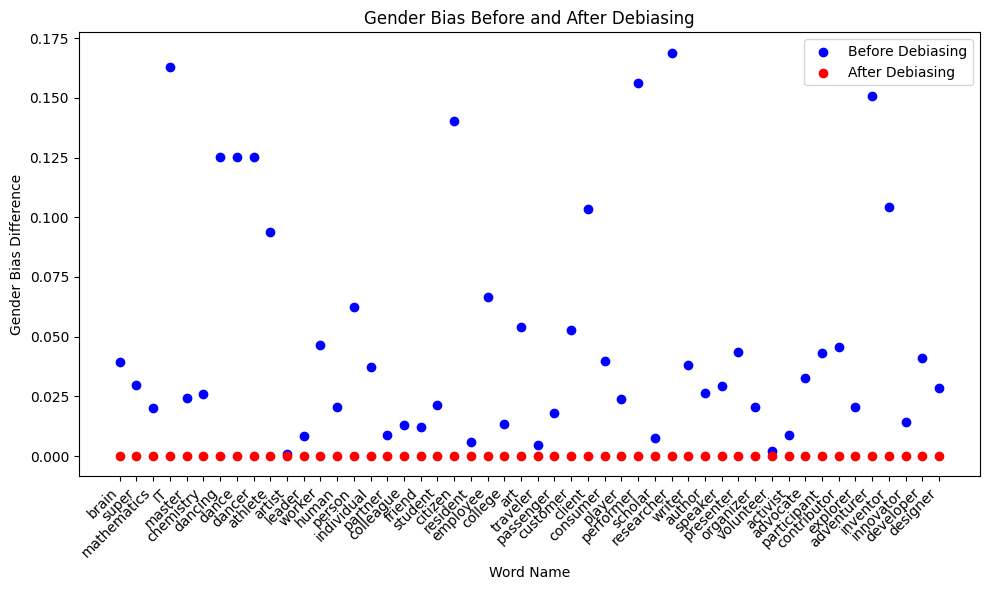

In [40]:
words_and_diffs = list(zip(gender_neutral_words, differences_before, differences_after_new))
sorted_words_and_diffs = sorted(words_and_diffs, key=lambda x: x[2])

gender_neutral_words_sorted, differences_before_sorted, differences_after_sorted = zip(*sorted_words_and_diffs)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(gender_neutral_words_sorted)), differences_before_sorted, label='Before Debiasing', color='blue')
plt.scatter(range(len(gender_neutral_words_sorted)), differences_after_sorted, label='After Debiasing', color='red')
plt.xlabel('Word Name')
plt.ylabel('Gender Bias Difference')
plt.title('Gender Bias Before and After Debiasing')
plt.legend()
plt.xticks(range(len(gender_neutral_words_sorted)), gender_neutral_words_sorted, rotation=45, ha='right')
plt.tight_layout()
plt.show()

### WEAT test

In [41]:
X = ["cool", "rich", "work", "wise", "bad"]
Y = ["strong", "poor", "smart", "business", "success"]
A = ['he', "male", "man"]
B = ['she', "female", "woman"]

In [42]:
def cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two vectors.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

In [43]:
def mean_cos_similarity(word_embedding, A_embeddings, B_embeddings):
    """
    Compute mean cosine similarity between word embedding and the mean of attribute word embeddings A and B.

    Args:
        word_embedding (numpy.ndarray): The embedding vector for the target word.
        A_embeddings (numpy.ndarray): Array containing embedding vectors for words in set A.
        B_embeddings (numpy.ndarray): Array containing embedding vectors for words in set B.

    Returns:
        float: The difference of mean cosine similarities.
    """
    mean_A = np.mean(A_embeddings, axis=0)
    mean_B = np.mean(B_embeddings, axis=0)

    cos_sim_A = cosine_similarity(word_embedding, mean_A)
    cos_sim_B = cosine_similarity(word_embedding, mean_B)

    return cos_sim_A - cos_sim_B

In [44]:
def weat_effect_size(X, Y, A, B):
    X_embed = np.array(X)
    Y_embed = np.array(Y)
    A_embed = np.array(A)
    B_embed = np.array(B)

    mean_X = np.mean([mean_cos_similarity(x, A_embed, B_embed) for x in X_embed])
    mean_Y = np.mean([mean_cos_similarity(y, A_embed, B_embed) for y in Y_embed])

    combined_embeddings = np.concatenate((X_embed, Y_embed))
    std_dev = np.std([mean_cos_similarity(w, A_embed, B_embed) for w in combined_embeddings])

    effect_size = (mean_X - mean_Y) / (std_dev + 0.0001)

    return effect_size

In [45]:
X_def = list(map(get_embeddings, X))
Y_def = list(map(get_embeddings, Y))
A_def = list(map(get_embeddings, A))
B_def = list(map(get_embeddings, B))

In [46]:
weat_effect_size(X_def, Y_def, A_def, B_def)

1.72798843395431

In [47]:
X_soft = []
Y_soft = []
for word in X:
  X_soft.append(soft_debias(word))

for word in Y:
  Y_soft.append(soft_debias(word))


In [48]:
weat_effect_size(X_soft, Y_soft, A_def, B_def)

-0.5695750538339774

In [49]:
A_hard, B_hard = [], []

for element in np.array(list(zip(A, B))):
  result = hard_debias(element)
  A_hard.append(result[0])
  B_hard.append(result[1])

In [50]:
weat_effect_size(X_soft, Y_soft, A_hard, B_hard)

0.0

### Updating embeddings

In [51]:
male = ["worker","firefighter","Soldier","police","pilot","Engineer","Surgeon",
"Mechanic","Software developer","CEO","Lawyer","Scientist","Architect","Electrician",
"Carpenter","Plumber","Farmer","driver","Chef","trainer","Astronaut"
,"Entrepreneur","Professor","analyst"
,"Investment","coach","athlete","Stockbroker","Welder","Surveyor"
,"technician","captain","Barista","Barber","Sommelier"
,"DJ (Disc Jockey)","Mixologist","supervisor","guard"]
female = ["Nurse","Teacher","Secretary","Receptionist","Flight attendant","Caregiver","Midwife"
,"Social worker","Hairdresser","Makeup artist","Fashion designer"
,"Interior decorator","Nurse practitioner","teacher","Librarian","Event planner"
,"Human resources manager","Ballet","dancer","model","therapist","Singer","Childcare"
,"Nutritionist","Psychologist","Veterinarian","Yoga","Cosmetologist","Fashion"
,"Wedding","designer","Art","Speech" ,"Esthetician","Massage"
,"Event" ,"Writer","Marketing", "manager","relations"]

model_embeddings = model.get_input_embeddings()
female_debiased = []
male_debiased = []
for index,value in enumerate(male):
    male_debiased.append([])
    for token in tokenizer.tokenize(value.lower()):
        male_debiased[index].append(soft_debias(token))

print("Woman")
for index,value in enumerate(female):
    female_debiased.append([])
    for token in tokenizer.tokenize(value.lower()):
        female_debiased[index].append(soft_debias(token))


Woman


In [52]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in many ways. They are more nurturing, more empathetic, and more compassionate. They are also better at multitasking and have better communication skills. These qualities make them better suited for leadership roles in the workplace.

However, women still face many challenges in the workplace. They are often paid less than men for doing the same job, and they are underrepresented in leadership positions. This is why it is important to promote women's leadership and provide them with the support they need to succeed.

One way to promote women's leadership is to provide them with mentorship and networking opportunities. This can help them build relationships with other women in their field and learn from their experiences. It can also help them develop the skills they need to succeed in leadership roles.

Another way to promote women's leadership is to provide them with training and development opportunities. This can help them build their skills and knowledge a

In [53]:
words_to_zero = ["Football","nurse","nurturing","empathetic","compassionate","math","science","beautiful","intelligent","creative"]
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
for i in words_to_zero:
    for token in tokenizer.tokenize(i.lower()):
        print(tokenizer.convert_tokens_to_ids(token))
        model_embeddings.weight.data[tokenizer.convert_tokens_to_ids(token)] = torch.tensor(soft_debias(token))
        model_embeddings_out.weight.data[tokenizer.convert_tokens_to_ids(token)] = torch.tensor(soft_debias(token))
model.set_input_embeddings(model_embeddings)
model.set_output_embeddings(model_embeddings_out)

15914
77
12321
77
3325
870
368
8071
6587
5589
11857
378
11018
16801
40544
4135
600
32940
20123
425


In [54]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in many ways. They are more nurturing, more empathic, and more compassionate. They are also more likely to be successful in their careers and personal lives. However, there are some areas where men are superior to women. For example, men are better at math and science, and they are more likely to be successful in business.

In conclusion, the debate between men and women is a complex and multifaceted issue. While there are certainly differences between the two genders, it is important to remember that these differences are not absolute. Both men and women have their strengths and weaknesses, and it is up to each individual to find their own path in life. Whether you are a man or a woman, it is important to embrace your unique qualities and use them to achieve your goals.<|endoftext|>


In [55]:
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
for i in range(100,10000):
    print(i)
    outputs = model(torch.tensor([[i]]))
    tokens_current = outputs.hidden_states[0].cpu()
    word = tokens_current[0][0].detach().numpy()
    projection = (projectors[0] @ word + projectors[1] @ word+ projectors[2] @ word +
          projectors[3] @ word+ projectors[4] @ word +
          projectors[5] @ word+ projectors[6] @ word)
    unbiased = word - projection
    model_embeddings.weight.data[i] = torch.tensor(unbiased)
    model_embeddings_out.weight.data[i] = torch.tensor(unbiased)
model.set_input_embeddings(model_embeddings)
model.set_output_embeddings(model_embeddings_out)

Показано результат, скорочений до останніх рядків (5000).
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
51

In [56]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in math, physics, chemistry, biology, psychology, economics, sociology, anthropology, linguistically, geography, archeologically, ethnologically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, 

In [57]:
inputs = tokenizer('''Men are better than women in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Men are better than women in math, physics, chemistry, biology, economics, psychology, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, anthropology, geography, linguistically, psychology, economics, sociology, an

In [58]:
male = ["worker","firefighter","Soldier","police","pilot","Engineer","Surgeon",
"Mechanic","Software developer","CEO","Lawyer","Scientist","Architect","Electrician",
"Carpenter","Plumber","Farmer","driver","Chef","trainer","Astronaut"
,"Entrepreneur","Professor","analyst"
,"Investment","coach","athlete","Stockbroker","Welder","Surveyor"
,"technician","captain","Barista","Barber","Sommelier"
,"DJ (Disc Jockey)","Mixologist","supervisor","guard"]
female = ["Nurse","Teacher","Secretary","Receptionist","Flight attendant","Caregiver","Midwife"
,"Social worker","Hairdresser","Makeup artist","Fashion designer"
,"Interior decorator","Nurse practitioner","teacher","Librarian","Event planner"
,"Human resources manager","Ballet","dancer","model","therapist","Singer","Childcare"
,"Nutritionist","Psychologist","Veterinarian","Yoga","Cosmetologist","Fashion"
,"Wedding","designer","Art","Speech" ,"Esthetician","Massage"
,"Event" ,"Writer","Marketing", "manager","relations"]

model_embeddings = model.get_input_embeddings()
female_debiased = []
male_debiased = []
for index,value in enumerate(male):
    male_debiased.append([])
    for token in tokenizer.tokenize(value.lower()):
        male_debiased[index].append(soft_debias(token))

print("Woman")
for index,value in enumerate(female):
    female_debiased.append([])
    for token in tokenizer.tokenize(value.lower()):
        female_debiased[index].append(soft_debias(token))


Woman


In [59]:
print(len(female_debiased[0]))


2


In [60]:
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
pair = hard_debias(("men","Women"))
model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("men")] = torch.tensor(pair[0])
model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("Women")] = torch.tensor(pair[1])
model_embeddings_out.weight.data[tokenizer.convert_tokens_to_ids("men")] = torch.tensor(pair[0])
model_embeddings_out.weight.data[tokenizer.convert_tokens_to_ids("Women")] = torch.tensor(pair[1])
model.set_input_embeddings(model_embeddings)
model.set_output_embeddings(model_embeddings_out)

In [61]:
words_to_zero = ["Football","nurse","nurturing","empathetic","compassionate","math","science","beautiful","intelligent","creative"]
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
for i in words_to_zero:
    for token in tokenizer.tokenize(i.lower()):
        print(tokenizer.convert_tokens_to_ids(token))
        model_embeddings.weight.data[tokenizer.convert_tokens_to_ids(token)] = torch.tensor(soft_debias(token))
        model_embeddings_out.weight.data[tokenizer.convert_tokens_to_ids(token)] = torch.tensor(soft_debias(token))
model.set_input_embeddings(model_embeddings)
model.set_output_embeddings(model_embeddings_out)

15914
77
12321
77
3325
870
368
8071
6587
5589
11857
378
11018
16801
40544
4135
600
32940
20123
425


In [57]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in math, physics, chemistry, biology, psychology, economics, sociology, anthropology, linguistically, geography, archeologically, ethnologically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, 

In [59]:
business_embedding = soft_debias('sports')
household_embedding = soft_debias('math')

business_embedding_tensor = torch.tensor(np.zeros(2560))
household_embedding_tensor = torch.tensor(household_embedding)

model_embeddings = model.get_input_embeddings()
model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("sports")] = business_embedding_tensor
model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("math")] = household_embedding_tensor
model.set_input_embeddings(model_embeddings)


<ipython-input-37-d777c46c7c1e>:8: RuntimeWarning: invalid value encountered in scalar divide
  similarity = dot_product / (norm_vec1 * norm_vec2)


In [60]:
words_to_zero = ["Football","nurturing","empathetic","compassionate"]
model_embeddings = model.get_input_embeddings()
model_embeddings_out = model.get_output_embeddings()
for i in words_to_zero:
    model_embeddings.weight.data[tokenizer.convert_tokens_to_ids(i)] = torch.tensor(soft_debias(i))
model.set_input_embeddings(model_embeddings)

In [61]:
model_embeddings = model.get_input_embeddings()
print(model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("better")])

tensor([-0.0106,  0.0149,  0.0050,  ..., -0.0095, -0.0198, -0.0063],
       device='cuda:0', dtype=torch.float16)


In [66]:
inputs = tokenizer('''Women are better than men in''', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Women are better than men in math, physics, chemistry, biology, psychology, economics, sociology, anthropology, linguistically, geography, archeologically, ethnologically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, ethnographically, 

In [63]:
inputs = tokenizer('''negotiation is''', return_tensors="pt", return_attention_mask=False)

outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


negotiation is, unfortunately, seldom practiced. Negotiation, contrary, entails compromise, collaboration, creativity, flexibility, empathy, patience, persistence, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patience, patien

In [64]:
math_embedding = soft_debias('math')
math_embedding_tensor = torch.tensor(math_embedding)

model_embeddings = model.get_input_embeddings()
model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("math")] = math_embedding_tensor



In [65]:
man, woman = hard_debias(('man', 'woman'))
man_embedding_tensor = torch.tensor(man)
woman_embedding_tensor = torch.tensor(woman)

model_embeddings = model.get_input_embeddings()
model_embeddings.weight.data[tokenizer.convert_tokens_to_ids("man")] = man_embedding_tensor

